# Data description & Problem statement: 
   The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. Please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
* Dataset is imbalanced. The data has 41188 rows and 20 columns.
* This is a classification problem. the classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Cross-validation of Logistic Regression model with L1 regularization
- Cross-validation of Logistic Regression model with L2 regularization
- Use grid-search along with C-V approach to find the best hyperparameters of Logistic Regression model with both L1 & L2 regularizations: Find the best LR model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best LR model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score:  0.94 
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Bank Marketing/bank data/bank-additional-full.csv', sep=';')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.drop(['pdays'], axis=1, inplace=True)

In [5]:
L_cat=['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
       'contact', 'month', 'day_of_week']
L_con=['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed' ]

In [6]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

encode_text_index(df, 'y')

    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

for c in L_cat:
    encode_text_dummy(df, c)
    
df.head(3)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month-mar,month-may,month-nov,month-oct,month-sep,day_of_week-fri,day_of_week-mon,day_of_week-thu,day_of_week-tue,day_of_week-wed
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,1,0,0,0


In [7]:
X=df.drop(['y'], axis=1)
y=df['y']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(X_train)
X_train=scalor_X.transform(X_train)
X_test=scalor_X.transform(X_test)

Max. Lasso score =  0.9328645444335514


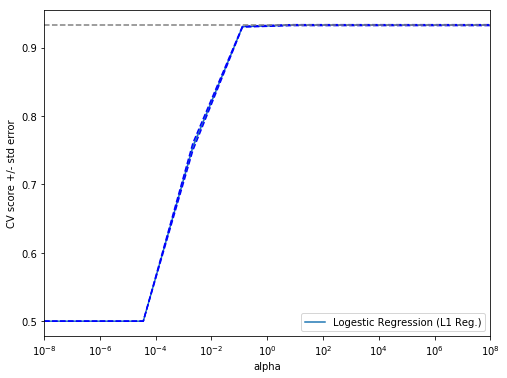

In [9]:
from sklearn.linear_model import LogisticRegression

# Cross-Validation for Logestic Regression algorithm: L1 Regularization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l1', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))


plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L1 Reg.)'])

Max. Lasso score =  0.9327796311631287


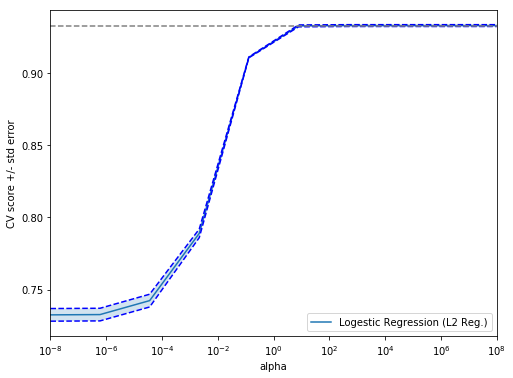

In [10]:
# Cross-Validation for Logestic Regression algorithm: L2 Regularization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l2', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))

plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L2 Reg.)'])

In [11]:
# Grid-Search for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param=[{'penalty':['l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000]} ,
       {'penalty':['l1'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_r, y_r=X_train, y_train
#X_r, y_r = SMOTE(random_state=42).fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)


kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param, cv=kfold, scoring="roc_auc")
grid_search.fit(X_r, y_r)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,31.819769,9.092789,0.006827,0.001304,1,l1,"{'C': 1, 'penalty': 'l1'}",0.934817,0.932338,0.938170,...,0.935157,0.001981,1,0.936862,0.937554,0.935938,0.936475,0.937062,0.936778,0.000546
9,65.496725,7.915201,0.025952,0.043924,10,l1,"{'C': 10, 'penalty': 'l1'}",0.934746,0.932298,0.938174,...,0.935113,0.001990,2,0.936885,0.937579,0.935960,0.936500,0.937079,0.936801,0.000546
10,42.876555,5.319673,0.004990,0.001259,100,l1,"{'C': 100, 'penalty': 'l1'}",0.934728,0.932298,0.938183,...,0.935110,0.001992,3,0.936885,0.937579,0.935959,0.936499,0.937080,0.936801,0.000546


In [12]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 1, 'penalty': 'l1'}
Best validation accuracy:  0.94 (+/- 0.00)
Test score:  0.94


Confusion matrix, without normalization
[[7843 1294]
 [ 103 1057]]
Normalized confusion matrix
[[0.86 0.14]
 [0.09 0.91]]


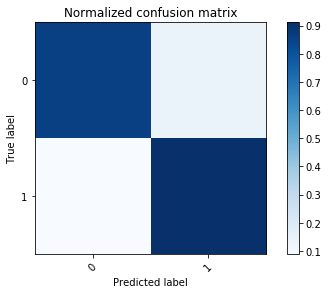

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [14]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.99      0.86      0.92      9137
          1       0.45      0.91      0.60      1160

avg / total       0.93      0.86      0.88     10297



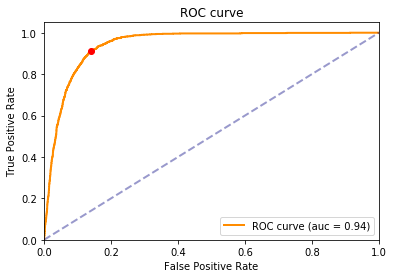

In [15]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

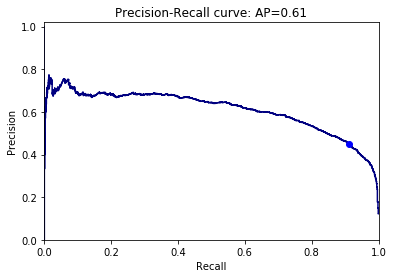

In [16]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(np.array(X_test))[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(np.array(X_test))[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()